# simple convolutional neural network

In [1]:
# load package and mnist
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../MNIST_data/', one_hot=True)
%matplotlib inline  
print ("PACKAGES LOADED")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
PACKAGES LOADED


## define cnn

In [2]:
# select device to be used
device_type = "/gpu:1"

with tf.device(device_type):
    n_input = 784
    n_output = 10
    weights = {
        'wc1': tf.Variable(tf.random_normal([3, 3, 1, 64], stddev=0.1)), 
        'wd1': tf.Variable(tf.random_normal([14*14*64, n_output], stddev=0.1))
    }
    biases = {
        'bc1': tf.Variable(tf.random_normal([64], stddev=0.1)),
        'bd1': tf.Variable(tf.random_normal([n_output], stddev=0.1))
    }
    
    def conv_simple(_input, _w, _b):
        #reshape input
        _input_r = tf.reshape(_input, shape=[-1, 28, 28, 1])
        # convolution
        _conv1 = tf.nn.conv2d(_input_r, _w['wc1'], strides=[1, 1, 1, 1], padding='SAME')
        # add bias
        _conv2 = tf.nn.bias_add(_conv1, _b['bc1'])
        # relu
        _conv3 = tf.nn.relu(_conv2)
        # max-pooling
        _pool = tf.nn.max_pool(_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        # vectorize
        _dense = tf.reshape(_pool, [-1, _w['wd1'].get_shape().as_list()[0]])
        # fully-connected layer
        _out = tf.add(tf.matmul(_dense, _w['wd1']), _b['bd1'])
        # return everything
        out = {
            'input_r': _input_r, 'conv1': _conv1, 'conv2': _conv2, 'conv3': _conv3,
            'pool': _pool, 'dense': _dense, 'out': _out
        }
        return out
print("cnn ready")


Instructions for updating:
Colocations handled automatically by placer.
cnn ready


## define computational graph

In [3]:
# tf graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_output])

# parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 100
display_step = 1 

# function
with tf.device(device_type):  # this is optional
    _pred = conv_simple(x, weights, biases)['out']
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=_pred, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    # accuracy
    _corr = tf.equal(tf.argmax(_pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(_corr, "float"))
    init = tf.global_variables_initializer()
    
# saver
save_step = 1
save_dir = "nets/"
saver = tf.train.Saver(max_to_keep=3)
print("Network ready to go")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Network ready to go


## optimize

In [4]:
do_train = 1 
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)

In [5]:
if do_train == 1:
    for epoch in range(training_epochs):
        avg_loss = 0
        n_batch = int(mnist.train.num_examples / batch_size)
        for batch in range(n_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            train_feed = {x: batch_xs, y: batch_ys}
            sess.run(optimizer, feed_dict=train_feed)            
            avg_loss += sess.run(loss, feed_dict=train_feed)
        avg_loss = avg_loss / n_batch
        
        # display
        if (epoch + 1) % display_step == 0:
            train_acc = sess.run(accuracy, feed_dict=train_feed)
            test_feed= {x: mnist.test.images, y: mnist.test.labels}
            test_acc = sess.run(accuracy, feed_dict=test_feed)
            print("Epoch: %03d/%03d  " "loss: %.5f  " "train accuracy: %.3f  " "test accuracy: %.3f"
             % (epoch + 1, training_epochs, avg_loss, train_acc, test_acc))
        print("optimization finished")

Epoch: 001/010  loss: 0.30885  train accuracy: 0.950  test accuracy: 0.964
optimization finished
Epoch: 002/010  loss: 0.09822  train accuracy: 0.970  test accuracy: 0.975
optimization finished
Epoch: 003/010  loss: 0.06696  train accuracy: 1.000  test accuracy: 0.980
optimization finished
Epoch: 004/010  loss: 0.05546  train accuracy: 0.990  test accuracy: 0.981
optimization finished
Epoch: 005/010  loss: 0.04639  train accuracy: 0.960  test accuracy: 0.981
optimization finished
Epoch: 006/010  loss: 0.04095  train accuracy: 1.000  test accuracy: 0.981
optimization finished
Epoch: 007/010  loss: 0.03505  train accuracy: 1.000  test accuracy: 0.980
optimization finished
Epoch: 008/010  loss: 0.03078  train accuracy: 0.980  test accuracy: 0.983
optimization finished
Epoch: 009/010  loss: 0.02780  train accuracy: 1.000  test accuracy: 0.983
optimization finished
Epoch: 010/010  loss: 0.02443  train accuracy: 0.990  test accuracy: 0.982
optimization finished


## restore

In [6]:
if do_train == 0:
    epoch = training_epochs -1 
    saver.restore(sess, "nets/cnn_mnist_simple.ckpt-" + str(epoch))
    print("network restored")

## see how cnn works

In [7]:
with tf.device(device_type):
    conv_out = conv_simple(x, weights, biases)

train_imgs = mnist.train.images
train_labels = mnist.train.labels
input_r = sess.run(conv_out['input_r'], feed_dict={x: train_imgs[0:1, :]})
conv1 = sess.run(conv_out['conv1'], feed_dict={x: train_imgs[0:1, :]}) 
conv2 = sess.run(conv_out['conv2'], feed_dict={x: train_imgs[0:1, :]})
conv3 = sess.run(conv_out['conv3'], feed_dict={x: train_imgs[0:1, :]})
pool = sess.run(conv_out['pool'], feed_dict={x: train_imgs[0:1, :]})
dense = sess.run(conv_out['dense'], feed_dict={x: train_imgs[0:1, :]})
out = sess.run(conv_out['out'], feed_dict={x: train_imgs[0:1, :]})

## input layer

size of  input_r is (1, 28, 28, 1)
label is 7


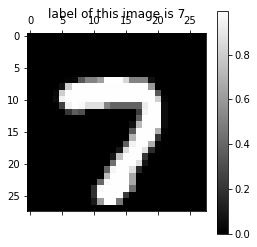

In [8]:
# let's see input layer
print ("size of  input_r is %s" %(input_r.shape, ))  # 注意此处有个逗号
label = np.argmax(train_labels[0, :])
print ("label is %d" %(label))

# plot
plt.matshow(input_r[0, :, :, 0], cmap = plt.get_cmap('gray'))
plt.title("label of this image is " + str(label) + "")
plt.colorbar()
plt.show()

## layer1 (convolution)

size of  conv1 is (1, 28, 28, 64)


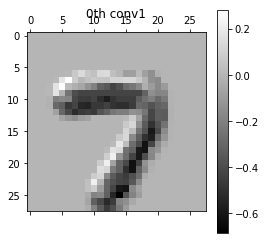

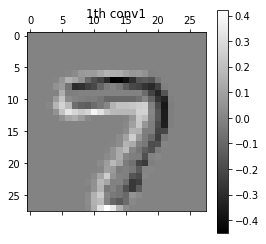

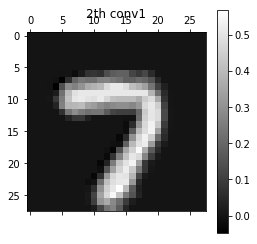

In [9]:
# Let's see 'conv1'
print ("size of  conv1 is %s" %(conv1.shape, ))
 
# plot
for i in range(3):
    plt.matshow(conv1[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv1")
    plt.colorbar()
    plt.show() 

## layer2(+bias)

Size of 'conv2' is (1, 28, 28, 64)


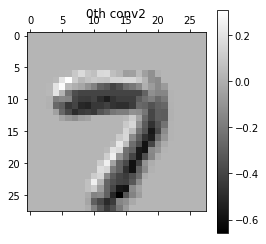

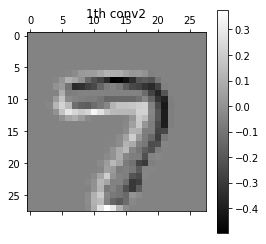

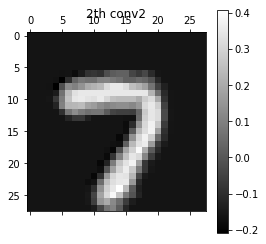

In [10]:
# Let's see 'conv2'
print ("Size of 'conv2' is %s" % (conv2.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(conv2[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv2")
    plt.colorbar()
    plt.show() 

## layer3(ReLU)

Size of 'conv3' is (1, 28, 28, 64)


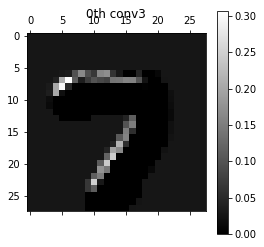

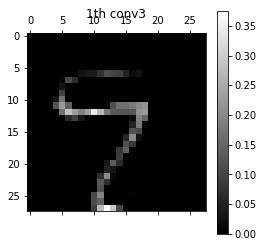

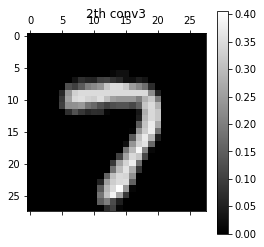

In [11]:
# Let's see 'conv3'
print ("Size of 'conv3' is %s" % (conv3.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(conv3[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv3")
    plt.colorbar()
    plt.show() 

## layer4(max_pool)

Size of 'pool' is (1, 14, 14, 64)


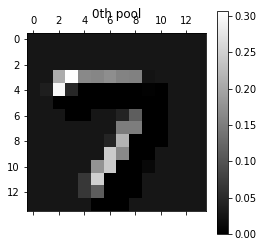

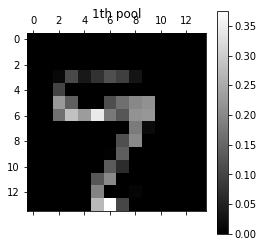

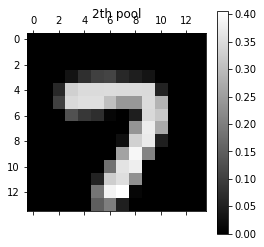

In [12]:
# Let's see 'pool'
print ("Size of 'pool' is %s" % (pool.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(pool[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th pool")
    plt.colorbar()
    plt.show() 

## full connected layer

In [13]:
# Let's see 'dense'
print ("Size of 'dense' is %s" % (dense.shape,))
# Let's see 'out'
print ("Size of 'out' is %s" % (out.shape,))

Size of 'dense' is (1, 12544)
Size of 'out' is (1, 10)


## filter

Size of 'wc1' is (3, 3, 1, 64)


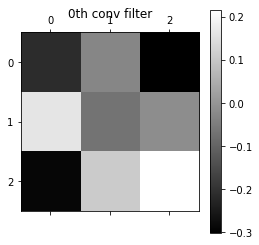

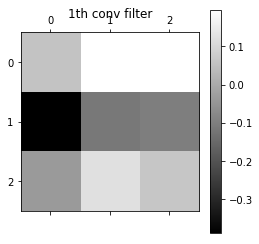

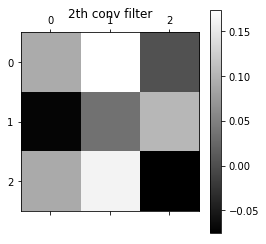

In [14]:
# Let's see weight! 
wc1 = sess.run(weights['wc1'])
print ("Size of 'wc1' is %s" % (wc1.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(wc1[:, :, 0, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv filter")
    plt.colorbar()
    plt.show()

In [1]:
# close
sess.close()

NameError: name 'sess' is not defined